In [46]:
!nvidia-smi

Thu Nov 13 10:31:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:B2:00.0 Off |                  N/A |
| 22%   22C    P8             17W /  250W |     306MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
import os
# NOTE!
# this is for a multi-gpu setup. we basically set which GPU is visible for the program.
# if you only have one GPU (most likely the case ;) ), make sure this is set to "0"!
# or remove this line completely!
# otherwise you may accidentally make your GPU "invisible" to the program!
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Pytorch Variational Autoencoder

The structure of this notebook is very similar to the famed Assignment 0! Refer back to that if anything is unclear.

## Data, Model, Training

In [8]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn

from lgm.autoencoder import image_reconstruction_examples, map_likelihood, loss_likelihood
from lgm.common import count_parameters, plot_learning_curves
from lgm.data import get_datasets_and_loaders
from lgm.layers import hidden_linear, CNNBody, Reshape, ConvBlockPrenorm
from lgm.vae import VAETrainer, VAEGauss

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

MNIST is okay as a start, but not very exciting -- heavily recommended to try another dataset as well! Check the code to see what is available.

Shape/dtype of batch X [N, C, H, W]: torch.Size([256, 1, 32, 32]), torch.float32
Shape/dtype of batch y: torch.Size([256]), torch.int64


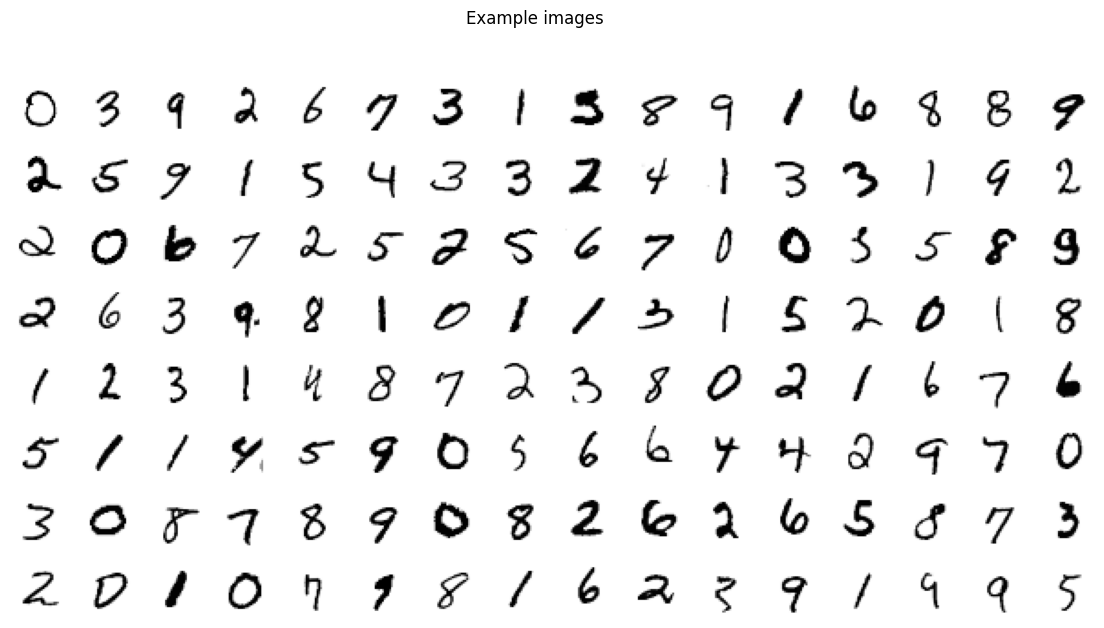

In [9]:
data = "mnist"
batch_size = 256

train_data, test_data, train_dataloader, test_dataloader = get_datasets_and_loaders(data, batch_size, num_workers=16)

For building the actual model architecture, you could look at the autoencoder notebook (`00_autoencoder_gauss_mnist.ipynb`) for some ideas (CNN ResNet).

In [10]:
input_shape = next(iter(train_dataloader))[0].shape[1:]

input_pixels = input_shape[1]
input_channels = input_shape[0]
input_pixels

32

In [126]:
def build_and_test_vae(train_dataloader,code_dim = 64 ):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device\n")

    

    input_shape = next(iter(train_dataloader))[0].shape[1:]
    input_pixels = input_shape[1]
    input_channels = input_shape[0]


    # Build an encoder model!
    # Remember: for some code_dim you need twice as many outputs for Gaussian q(z|x).
    encoder = nn.Sequential()
    encoder.append(nn.Flatten())
    encoder.append(nn.Linear(input_pixels*input_pixels*input_channels,512))
    encoder.append(nn.ReLU())
    encoder.append(nn.Linear(512,256))
    encoder.append(nn.ReLU())
    encoder.append(nn.Linear(256,128))
    encoder.append(nn.ReLU())
    encoder.append(nn.Linear(128,code_dim * 2))



    # NOTE you should set up your decoder such that the final layer has no activation function!
    # This will ensure correct mapping via the map_likelihood function.
    decoder = nn.Sequential()
    decoder.append(nn.Linear(code_dim ,128))
    decoder.append(nn.ReLU())
    decoder.append(nn.Linear(128,256))
    decoder.append(nn.ReLU())
    decoder.append(nn.Linear(256,512))
    decoder.append(nn.ReLU())
    decoder.append(nn.Linear(512,input_pixels*input_pixels*input_channels))
    decoder.append(nn.Unflatten(dim=1, unflattened_size=(input_channels, input_pixels, input_pixels)))


    likelihood = "gaussian_fixed_sigma"
    # since nn.Modules generally don't know their own input shape,
    # we have to provide the dimensionality of our prior distribution to the model (4th argument that is currently ???).
    # this is so that we can sample from this distribution in the generate() function.
    model = VAEGauss(encoder, decoder, likelihood, code_dim)

    # we have to run the model once to initialize any lazy layers.
    # this also allows us to check whether the AE output has the correct shape.
    model = model.to(device)
    with torch.no_grad():
        test_output = map_likelihood(model(next(iter(train_dataloader))[0].to(device)), likelihood)

    print("\n")
    print("test output shape")
    print(test_output.shape)
    if test_output.shape[1] != input_channels:
        raise ValueError(f"WARNING! Expected {input_channels} output channels but got {test_output.shape[1]}")
    if test_output.shape[2] != input_pixels:
        raise ValueError(f"WARNING! Expected {input_pixels} output pixels but got {test_output.shape[2]}")

    model.compile()
    return model


In [57]:
model = build_and_test_vae(train_dataloader)
num_params = count_parameters(model)
print(f"Model with {num_params:,d} trainable parameters!")

Using cuda device



test output shape
torch.Size([256, 1, 32, 32])
Model with 1,403,776 trainable parameters!


You can shorten the training if it takes too long. But you should get used to the fact that good models take time. :)

In [68]:
def build_trainer(model, train_dataloader, test_dataloader, beta, n_epochs=150):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    optimizer = torch.optim.AdamW(
        model.parameters(),
        weight_decay=0.1,
        amsgrad=True
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=n_epochs
    )

    trainer = VAETrainer(
        likelihood=likelihood,
        beta=beta,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        training_loader=train_dataloader,
        validation_loader=test_dataloader,
        n_epochs=n_epochs,
        device=device,
        plot_every_n_epochs=149,
        verbose=True
    )

    return trainer


In [ ]:
betas = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
all_results = {}  

for i, beta in enumerate(betas, start=1):
    model = build_and_test_vae(train_dataloader)
    
    trainer = build_trainer(model, train_dataloader, test_dataloader, beta)
    metrics = trainer.train_model()
    
    all_results[beta] = {
        "model": model,
        "trainer": trainer,
        "metrics": metrics
    }
    
    print(f"####################### Model {i} trained with beta={beta} ###############################")


In [72]:
for beta, info in all_results.items():
    info["trainer"].evaluate()

Note, it's pretty normal to see the KL divergence go _up_ over time.

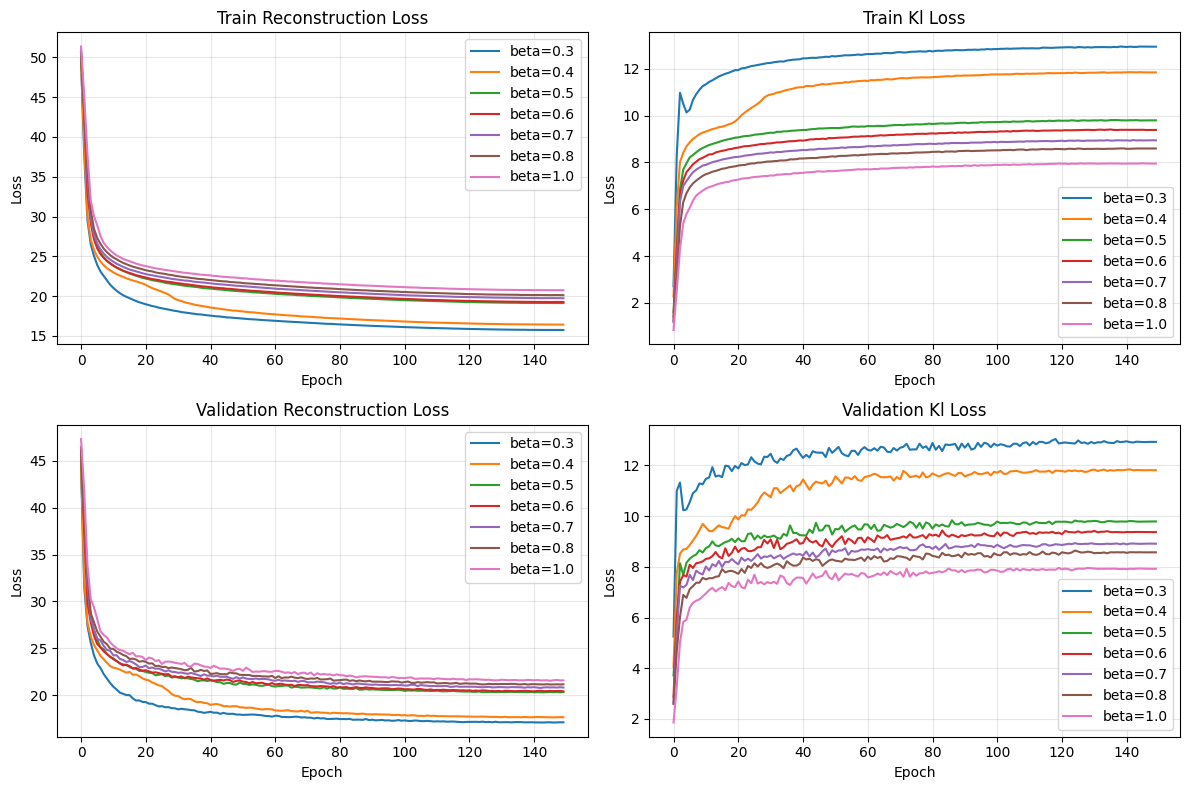

In [102]:
# This code to plot loss is generated with the help of chatgpt
losses = ["reconstruction_loss", "kl_loss"]
curves = ["train", "val"]

plt.figure(figsize=(12, 8))

for i, loss in enumerate(losses):
    plt.subplot(2, 2, i + 1)  
    for beta in betas:
        key = f"train_{loss}"
        if key in all_results[beta]["metrics"]:
            plt.plot(all_results[beta]["metrics"][key], label=f"beta={beta}")
    plt.title(f"Train {loss.replace('_', ' ').title()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()

for i, loss in enumerate(losses):
    plt.subplot(2, 2, i + 3)  
    for beta in betas:
        key = f"val_{loss}"
        if key in all_results[beta]["metrics"]:
            plt.plot(all_results[beta]["metrics"][key], label=f"beta={beta}")
    plt.title(f"Validation {loss.replace('_', ' ').title()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()


### Reconstructions

VAE reconstructions are usually much worse than standard autoencoders. :(

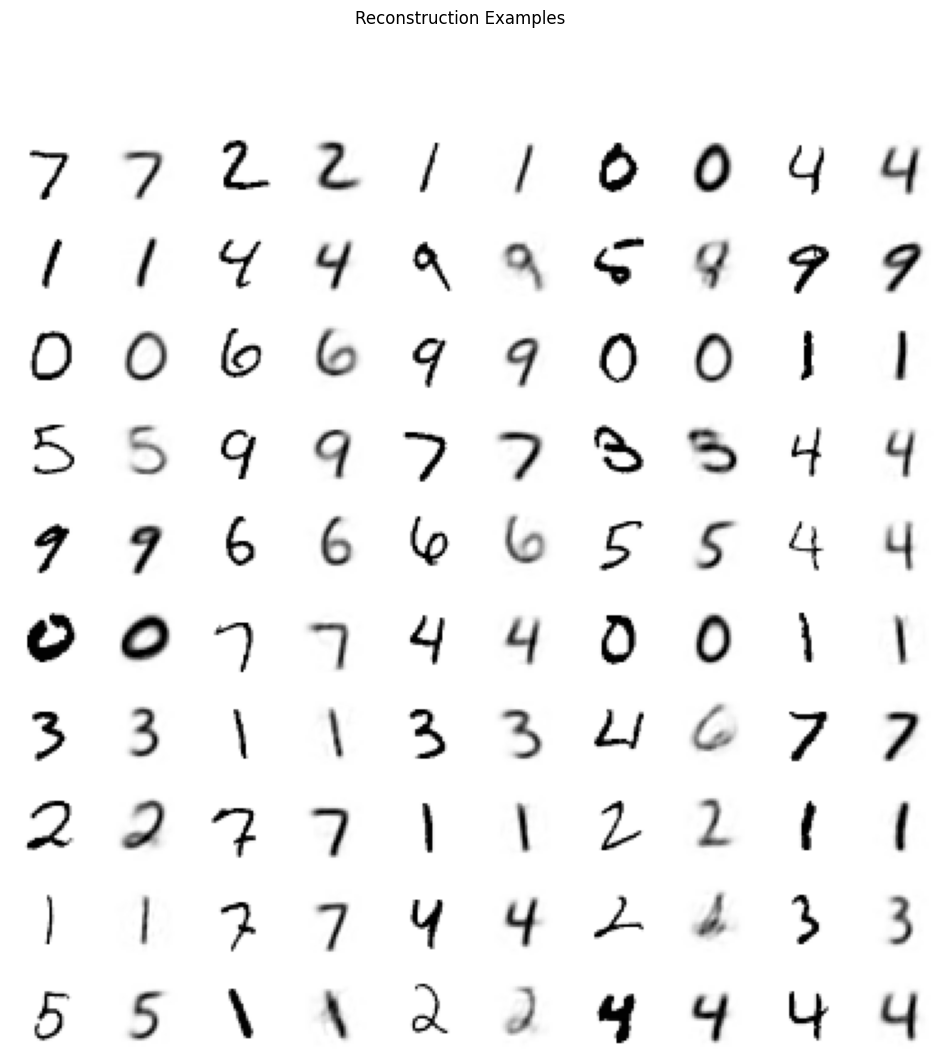

In [117]:
model = all_results[0.5]['model']
image_reconstruction_examples(model, likelihood, test_dataloader)

## Generating Images

Generating images is fast and easy!

Generated results for beta = 0.3


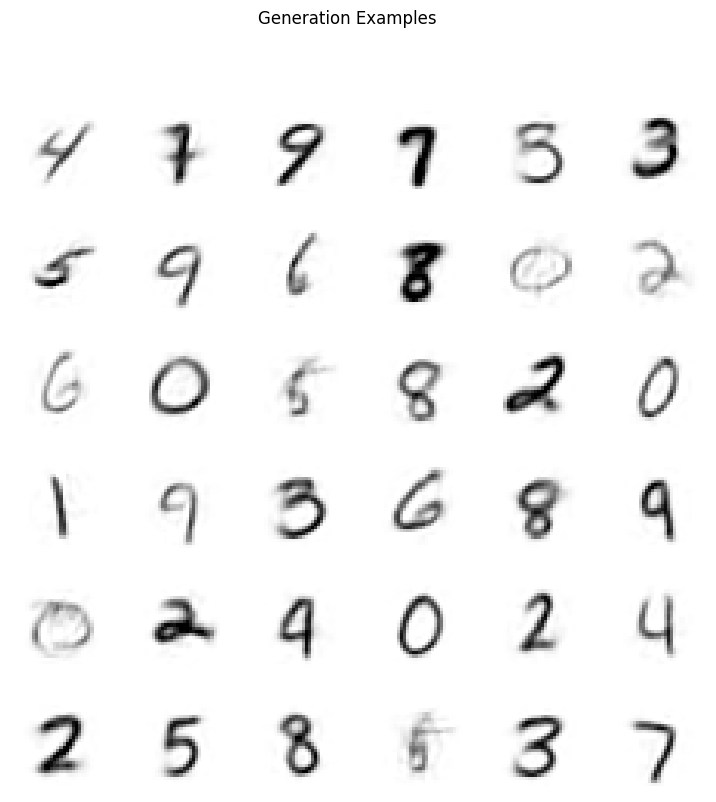

Generated results for beta = 0.4


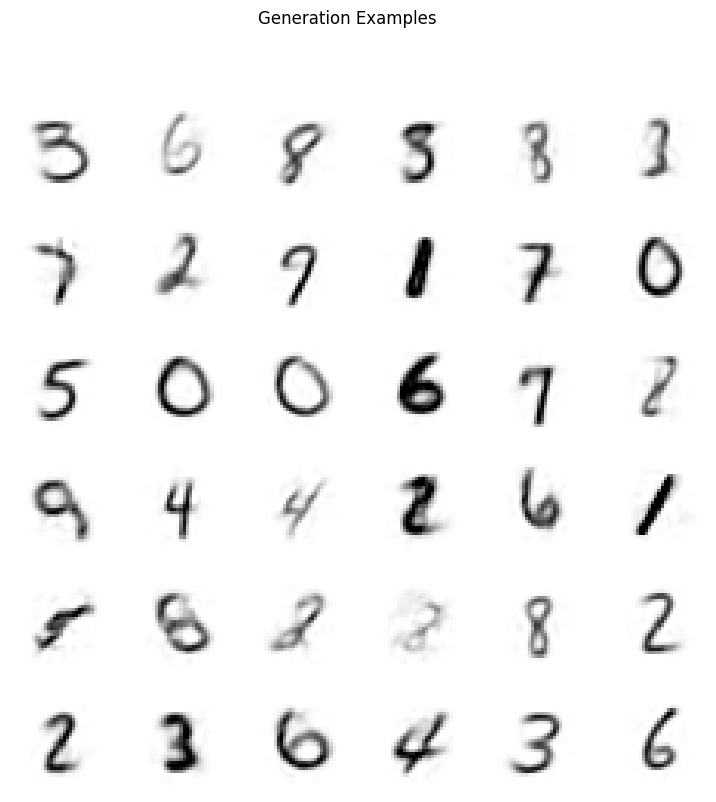

Generated results for beta = 0.5


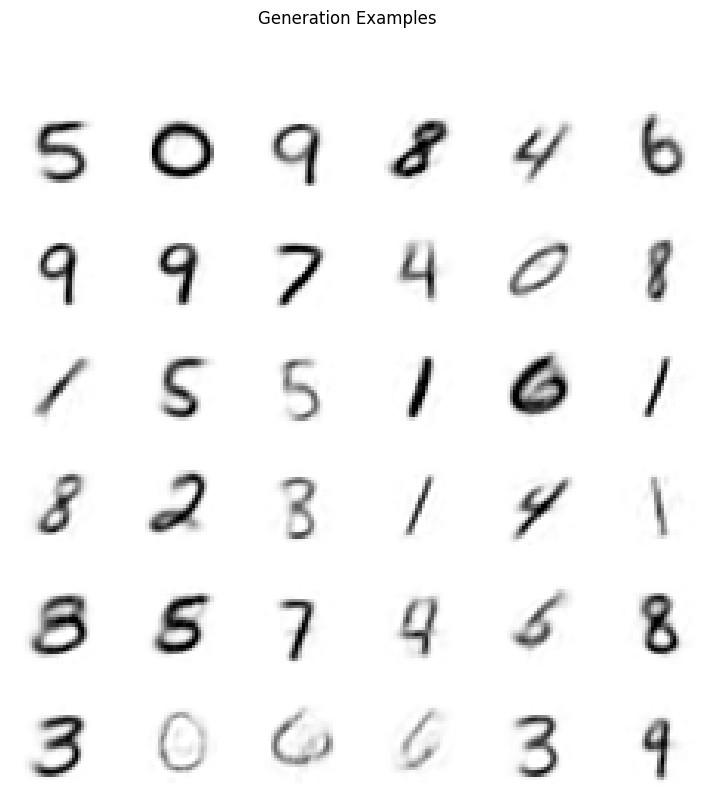

Generated results for beta = 0.6


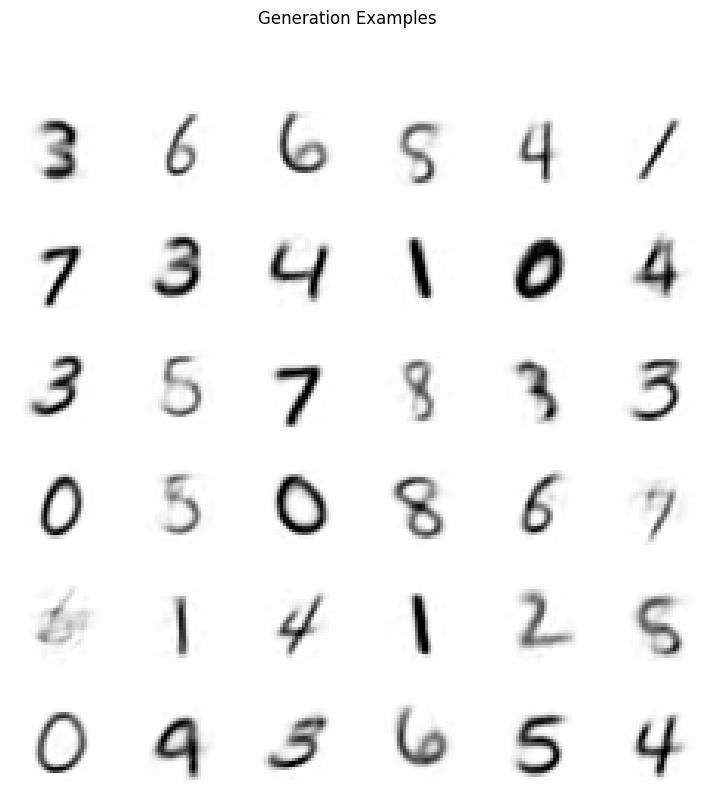

Generated results for beta = 0.7


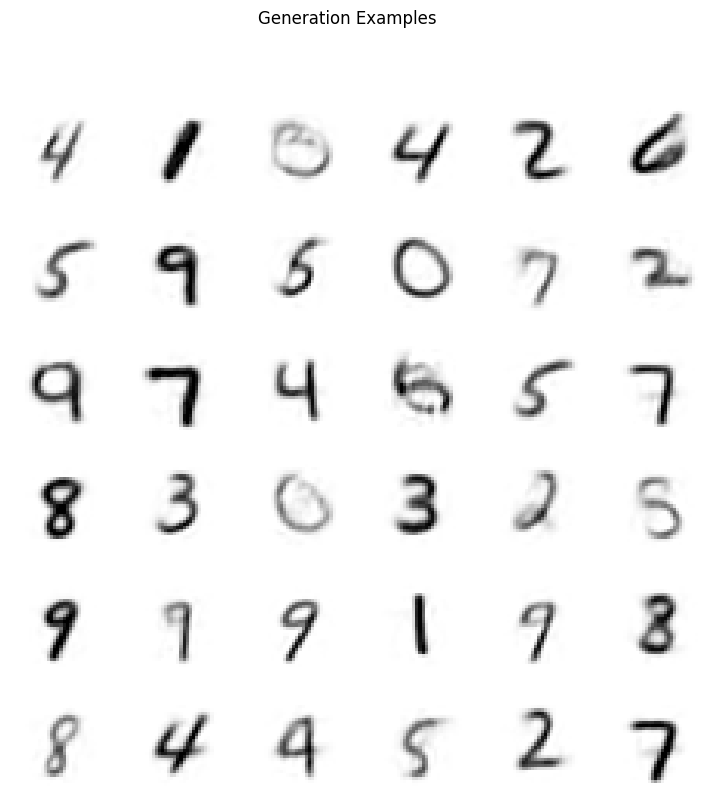

Generated results for beta = 0.8


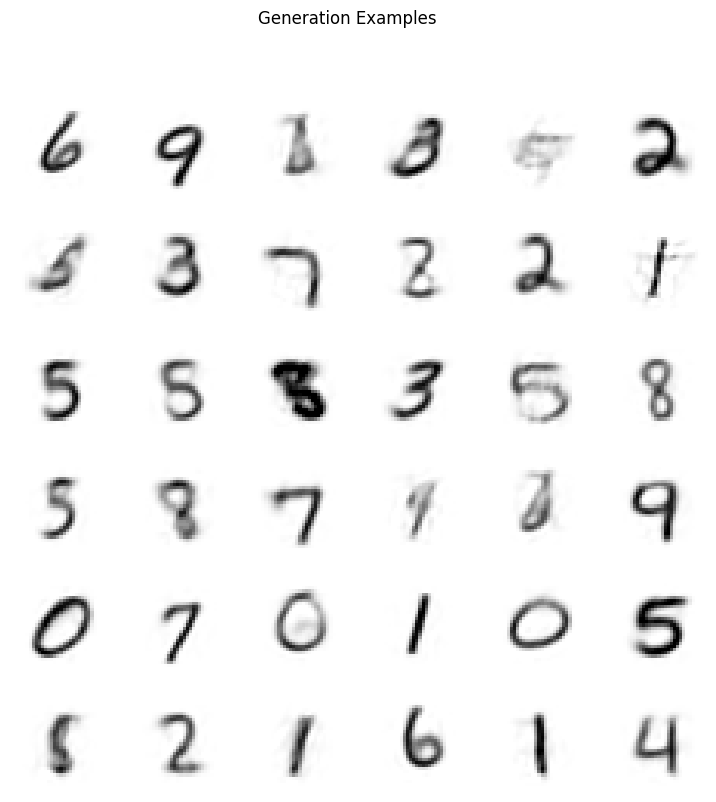

Generated results for beta = 1.0


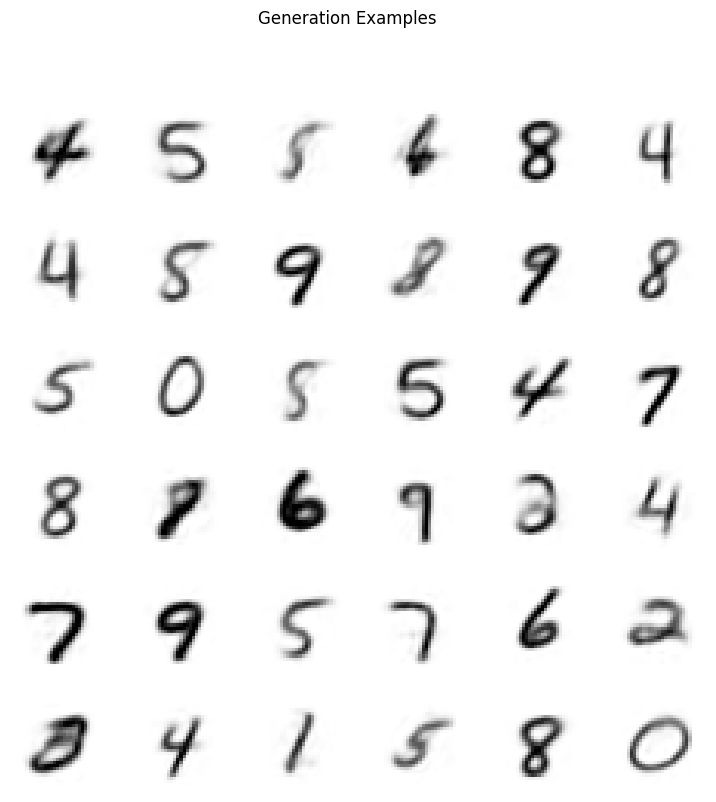

In [114]:
for beta, info in all_results.items():
    print(f"Generated results for beta = {beta}")
    model = info['model']
    
    with torch.inference_mode():
        generations = model.generate(36)
    plt.figure(figsize=(9, 9))
    for ind, img in enumerate(generations):
        plt.subplot(6, 6, ind + 1)
        plt.imshow(img.cpu().permute((1, 2, 0)), vmin=0, vmax=1, cmap="Greys")
        plt.axis("off")
    plt.suptitle("Generation Examples")
    plt.show()

## Latent Space Exploration

First off, we can get (sampled) encodings for the entire dataset and check their distributions. You will likely see some deviations from the ideal Gaussian "bells", where our approximate `q(z)` doesn't match the prior `p(z)`.

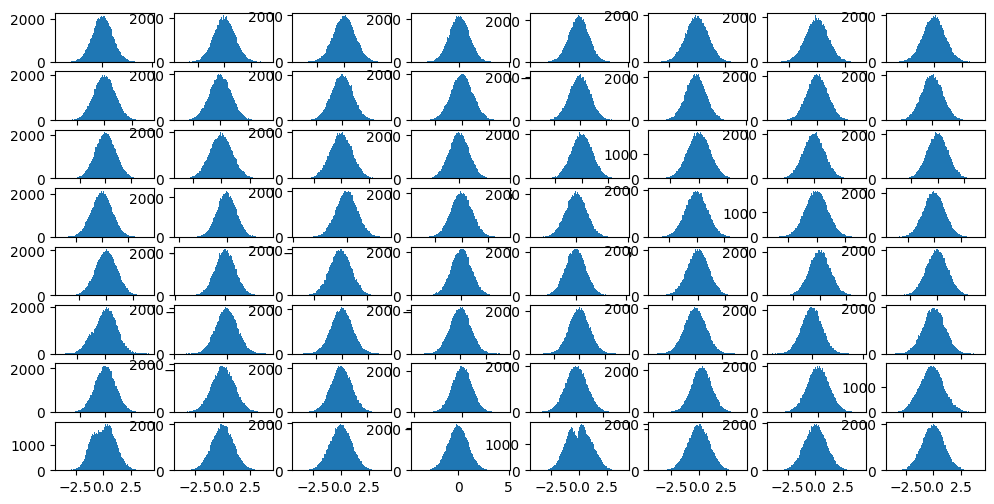

In [118]:
all_codes = []
with torch.no_grad():
    for input_batch, _ in train_dataloader:
        batch_encoded = model.sampler(*model.encoding_parameters(input_batch.to(device)))
        all_codes.append(batch_encoded)

all_codes = torch.cat(all_codes, dim=0)

# if you change dim_code you will have to adapt how many subplots to create here.
# e.g. 16 * 8 = 128
plt.figure(figsize=(12, 12))
for ind, codes_dim in enumerate(all_codes.T):
    plt.subplot(16, 8, ind+1)
    plt.hist(codes_dim.cpu().numpy(), bins=100)
plt.show()

### Interpolation

We can encode two images, interpolate between them, and decode along the way!

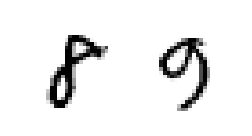

In [122]:
# pick two random images and plot
randind1 = np.random.randint(len(test_data))
randind2 = np.random.randint(len(test_data))

# annoying indexing since we only want 1 image but need a batch axis for model inputs.
# first get random index, then 0 to only get the image (not label), then add batch axis
image1 = test_data[randind1][0][torch.newaxis]
image2 = test_data[randind2][0][torch.newaxis]

with torch.inference_mode():
    code1 = model.sampler(*model.encoding_parameters(image1.to(device))).cpu().numpy()[0]
    code2 = model.sampler(*model.encoding_parameters(image2.to(device))).cpu().numpy()[0]

n_interpolation = 64
interpolation_coeffs = np.linspace(0, 1, n_interpolation)


interpolation = "slerp"  # or "linear"
# due to "reasons", spherical interpolation may be more appropriate

# note, the 0 indexing in here is just to get rid of the batch axis
interpolated_codes = []
for coefficient in interpolation_coeffs:
    if interpolation == "linear":
        interpolated_codes.append(coefficient*code2 + (1 - coefficient)*code1)
    elif interpolation == "slerp":
        angle = np.arccos(np.dot(code1, code2) / (np.linalg.norm(code1)*np.linalg.norm(code2)))
        interpolated_codes.append(np.sin((1-coefficient)*angle)/np.sin(angle) * code1 
                                  + np.sin(coefficient*angle)/np.sin(angle) * code2)
    else:
        raise ValueError("invalid interpolation")
interpolated_codes = np.array(interpolated_codes)


# see the images we are dealing with here
concated = np.concatenate((image1[0], image2[0]), axis=2).transpose(1, 2, 0)
plt.figure(figsize=(3,3))
plt.imshow(concated, cmap="Greys", vmin=0, vmax=1)
plt.axis("off")
plt.show()

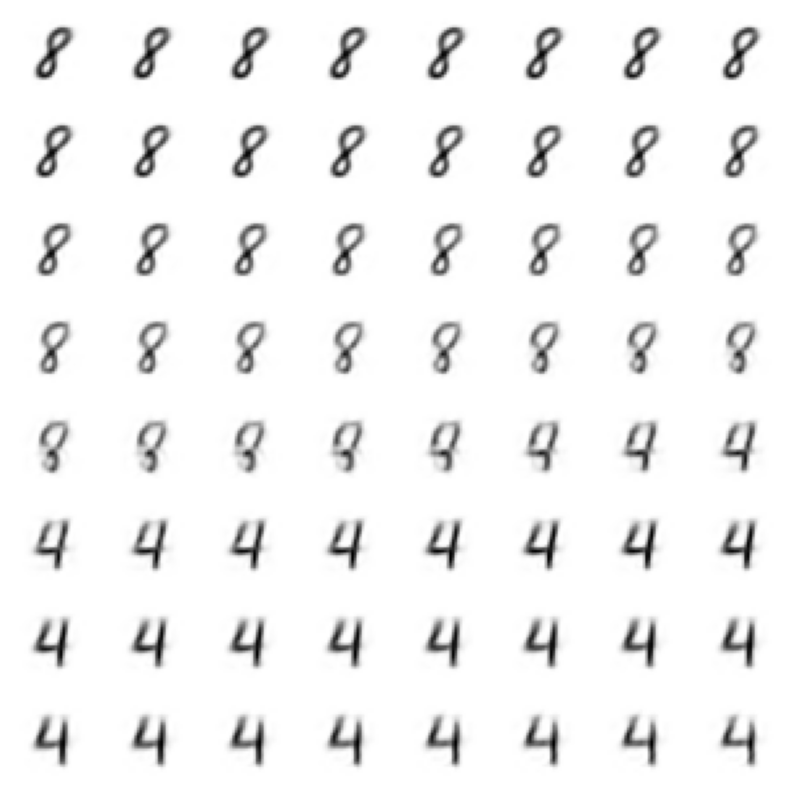

In [123]:
# actually look at the interpolations
# NOTE that the 2D grid layout implies there's something 2D happening here.
# it's not. it's just saves space to display the images this way.
# it's a 1d interpolation from top left to bottom right.
# it would be clearer to plot it all in one row or column.
with torch.inference_mode():
    interpolated_images = map_likelihood(
        model.decoder(torch.tensor(interpolated_codes, dtype=torch.float32, device=device)), likelihood).cpu().numpy()
plt.figure(figsize=(8, 8))
for ind in range(64):
    plt.subplot(8, 8, ind+1)
    plt.imshow(interpolated_images[ind].transpose(1, 2, 0), cmap="Greys", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()
plt.show()

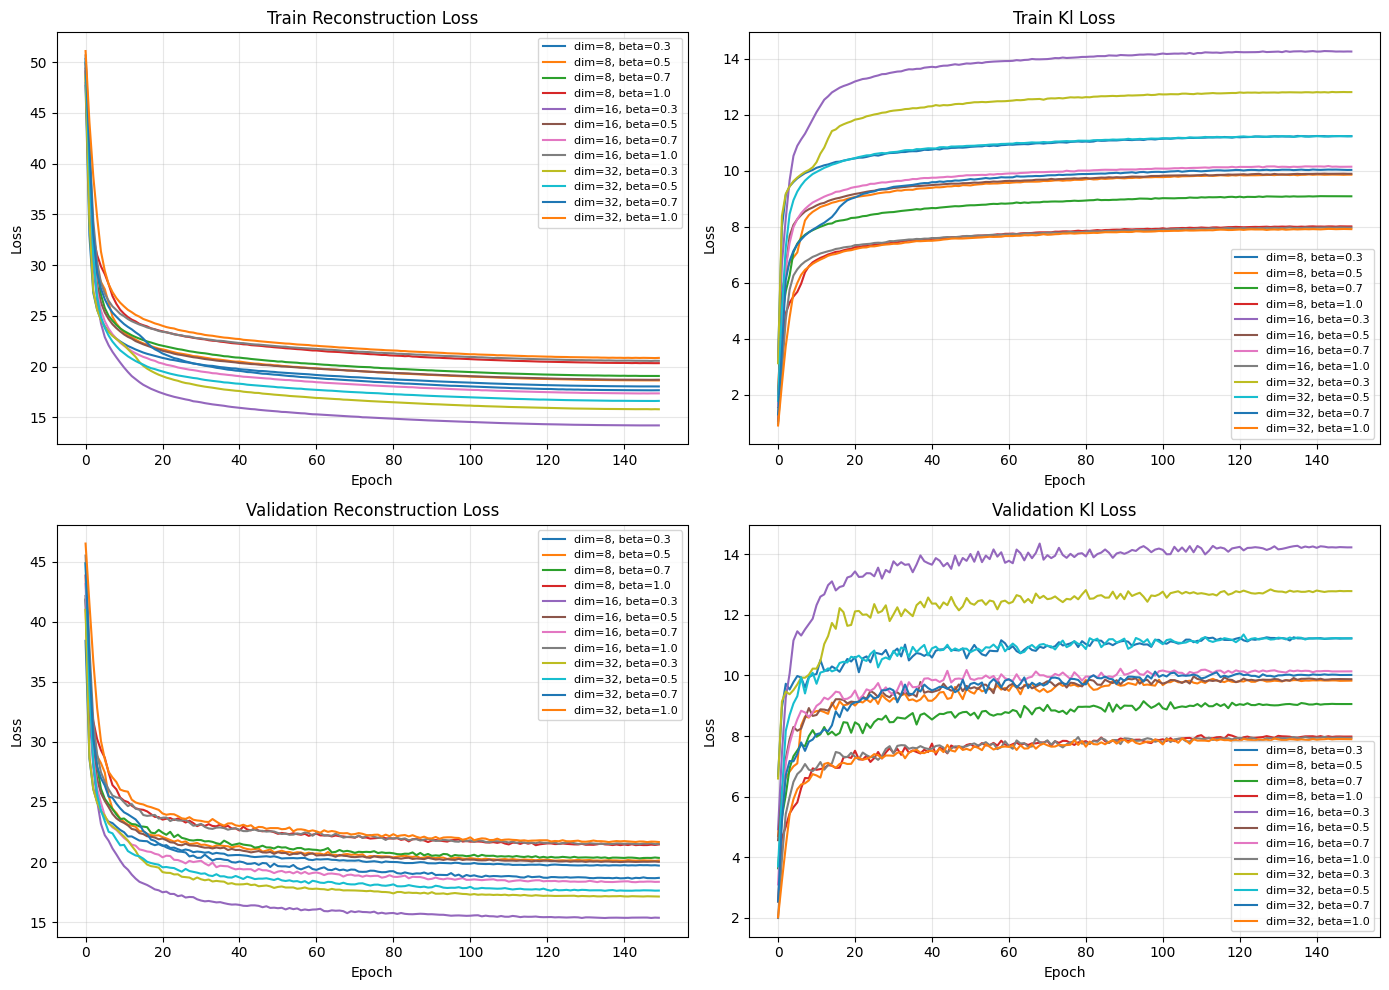

In [131]:
losses = ["reconstruction_loss", "kl_loss"]
curves = ["train", "val"]

plt.figure(figsize=(14, 10))

for i, loss in enumerate(losses):
    plt.subplot(2, 2, i + 1)
    for code in codes_dim:
        for beta in betas:
            metrics = dim_beta_results[(code, beta)]["metrics"]
            key = f"train_{loss}"
            if key in metrics:
                plt.plot(metrics[key], label=f"dim={code}, beta={beta}")
    plt.title(f"Train {loss.replace('_', ' ').title()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)

    plt.subplot(2, 2, i + 3)
    for code in codes_dim:
        for beta in betas:
            metrics = dim_beta_results[(code, beta)]["metrics"]
            key = f"val_{loss}"
            if key in metrics:
                plt.plot(metrics[key], label=f"dim={code}, beta={beta}")
    plt.title(f"Validation {loss.replace('_', ' ').title()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
